In [1]:
import uproot
import numpy as np
import glob
import os
import sys
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
import tensorflow.keras.backend as K
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow import keras
from tensorflow.keras import layers, models, Model

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
file = uproot.open('datasets/merged_HHbbbb_10000_0_train.root')
tree = file['CaloTree']
data = tree.arrays(library="np")

for branch, array in data.items():
    print(f"{branch}")

ncell_isHS
cell_isHS
ncell_et
cell_et
ncell_x
cell_x
ncell_y
cell_y
ncell_z
cell_z
ncell_sampling
cell_sampling
ncell_topo
cell_topo
EventNumber
nEventWeight
EventWeight
nTruthJets_pt
TruthJets_pt
nTruthJets_eta
TruthJets_eta
nTruthJets_phi
TruthJets_phi
nTruthPartons_VtxZ
TruthPartons_VtxZ
nTruthPartons_pt
TruthPartons_pt
nTruthPartons_eta
TruthPartons_eta
nTruthPartons_phi
TruthPartons_phi
ncell_4sig
cell_4sig


In [ ]:
def cell_to_grid(data):
    # cell vector xyz to angles eta phi
    def compute_eta_phi(x, y, z):
        phi = np.arctan2(y, x)
        p = np.sqrt(x**2 + y**2 + z**2)
        eta = 0.5 * np.log((p + z) / (p - z))
        return eta, phi

    eta_list = []
    phi_list = []

    for x_arr, y_arr, z_arr in zip(data['cell_x'], data['cell_y'], data['cell_z']):
        eta, phi = compute_eta_phi(x_arr, y_arr, z_arr)
        eta_list.append(eta)
        phi_list.append(phi)

    data['cell_eta'] = np.array(eta_list, dtype=object)
    data['cell_phi'] = np.array(phi_list, dtype=object)

    # binning for the grid data
    eta_bins = np.arange(-2.5, 2.5 + 0.1, 0.1)
    phi_bins = np.arange(-np.pi, np.pi + np.pi/32, np.pi/32)

    # data['cell_XXX'] is an array of 1d arrays with different shapes (no. of cell deposits)
    n_events = len(data['cell_eta'])

    # grid data format, separating HS and PU deposits
    X_isHS = np.zeros((n_events, len(phi_bins)-1, len(eta_bins)-1, 6))
    X_isPU = np.zeros((n_events, len(phi_bins)-1, len(eta_bins)-1, 6))

    # loop over events
    for i in range(n_events):
        # these contain deposit info per cell
        cell_eta    = data['cell_eta'][i]
        cell_phi    = data['cell_phi'][i]
        cell_et     = data['cell_et'][i] / 1000. # MeV -> GeV
        cell_sampling = data['cell_sampling'][i]
        cell_isHS   = data['cell_isHS'][i]

        abs_eta = np.abs(cell_eta)
        # conditions for separating channels according to the atlas calorimeter sampling layers
        cond_ch0 = ((cell_sampling == 0) & (abs_eta < 1.5)) | \
                ((cell_sampling == 4) & (abs_eta > 1.5) & (abs_eta < 1.8))
        
        cond_ch1 = ((cell_sampling == 1) & (abs_eta < 1.5)) | \
                ((cell_sampling == 5) & (abs_eta > 1.5) & (abs_eta < 2.5))
        
        cond_ch2 = ((cell_sampling == 2) & (abs_eta < 1.5)) | \
                ((cell_sampling == 6) & (abs_eta > 1.5) & (abs_eta < 2.5))
        
        cond_ch3 = ((cell_sampling == 3) & (abs_eta < 1.5)) | \
                ((cell_sampling == 7) & (abs_eta > 1.5) & (abs_eta < 2.5))
        
        cond_ch4 = ((cell_sampling == 12) & (abs_eta < 1)) | \
                ((cell_sampling == 18) & (abs_eta > 1.1) & (abs_eta < 1.5)) | \
                ((cell_sampling == 8)  & (abs_eta > 1.5) & (abs_eta < 2.5))
        
        cond_ch5 = ((cell_sampling == 13) & (abs_eta < 0.9)) | \
                ((cell_sampling == 19) & (abs_eta > 1)   & (abs_eta < 1.5)) | \
                ((cell_sampling == 15) & (abs_eta > 0.9) & (abs_eta < 1))   | \
                ((cell_sampling == 9)  & (abs_eta > 1.5) & (abs_eta < 2.5))
        
        conditions = [cond_ch0, cond_ch1, cond_ch2, cond_ch3, cond_ch4, cond_ch5]
        
        # loop over channel
        for ch in range(len(conditions)):
            mask = conditions[ch]
            # further separate HS and PU deposits
            hs_mask = mask & (cell_isHS == 1)
            pu_mask = mask & (cell_isHS == 0)
            
            # get HS cells per layer
            eta_hs = cell_eta[hs_mask]
            phi_hs = cell_phi[hs_mask]
            et_hs  = cell_et[hs_mask]
            hist_hs, _, _ = np.histogram2d(eta_hs, phi_hs, bins=[eta_bins, phi_bins], weights=et_hs)
            
            # get PU cells per layer
            eta_pu = cell_eta[pu_mask]
            phi_pu = cell_phi[pu_mask]
            et_pu  = cell_et[pu_mask]
            hist_pu, _, _ = np.histogram2d(eta_pu, phi_pu, bins=[eta_bins, phi_bins], weights=et_pu)
            
            X_isHS[i, :, :, ch] = hist_hs.T
            X_isPU[i, :, :, ch] = hist_pu.T

    return eta_bins, phi_bins, X_isHS, X_isPU
        
eta_bins, phi_bins, X_isHS, X_isPU = cell_to_grid(data)

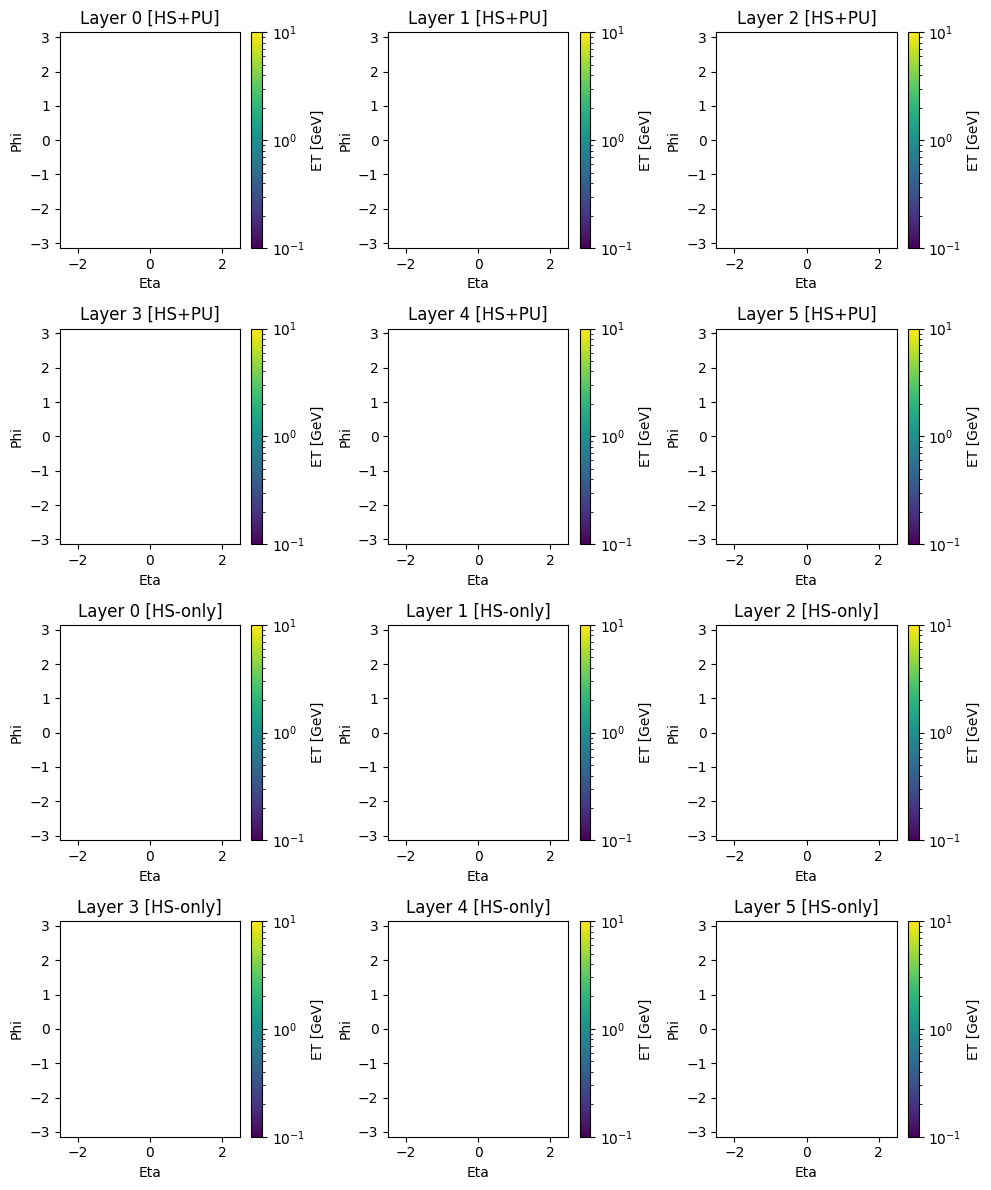

In [6]:
def plot_layers(event_idx, X_isHS, X_isPU):
    fig, axes = plt.subplots(4, 3, figsize=(10, 12))

    for ch in range(6):
        ax = axes[ch // 3, ch % 3]
        
        heatmap_data = X_isPU[event_idx, :, :, ch] + X_isHS[event_idx, :, :, ch]
        
        mesh = ax.pcolormesh(eta_bins,
                             phi_bins,
                             heatmap_data,
                             cmap='viridis',
                             norm = LogNorm(vmin = 1e-1, vmax = 1e1))
        
        ax.set_xlabel('Eta')
        ax.set_ylabel('Phi')
        ax.set_title(f'Layer {ch} [HS+PU]')
        
        fig.colorbar(mesh, ax=ax, label='ET [GeV]')

    for ch in range(6):
        ax = axes[ch // 3 + 2, ch % 3]
        
        heatmap_data = X_isHS[event_idx, :, :, ch]
        
        mesh = ax.pcolormesh(eta_bins,
                             phi_bins,
                             heatmap_data,
                             cmap='viridis',
                             norm = LogNorm(vmin = 1e-1, vmax = 1e1))
        
        ax.set_xlabel('Eta')
        ax.set_ylabel('Phi')
        ax.set_title(f'Layer {ch} [HS-only]')
        
        fig.colorbar(mesh, ax=ax, label='ET [GeV]')

    plt.tight_layout()
    plt.show()

plot_layers(event_idx=1, X_isHS=X_isHS, X_isPU=X_isPU)